<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model comparison on COCO 2017 dataset
*   SSD300 VGG16
*   Faster R-CNN ResNet-50 FPN
*   Mask R-CNN ResNet-50 FPN
*   YOLOv5s
*   YOLOv5m

Note: GPU Runtime needed






### Get requirements

In [ ]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

In [ ]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv assets ../
rm -rf /content/object-detection-assets/

### Import packages

In [22]:
# Import packages

from google.colab import files

import os, sys
import math
import time
import copy

import numpy as np
import json
import PIL

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

import assets.utils as AU
import assets.transforms as AT
import assets.coco_utils as ACU
from assets.coco_eval import CocoEvaluator

import yolov5

### Define auxiliary functions

In [35]:
# Copied and adjusted from repo pytorch/vision/references/detection/engine.py
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, M.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, M.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


# Copied and adjusted from repo pytorch/vision/references/detection/engine.py
@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = AU.MetricLogger(delimiter="  ")
    header = 'Test:'
    coco = ACU.get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    # Get label names
    label_ids = data_loader.dataset.coco.getCatIds()
    label_info = data_loader.dataset.coco.loadCats(label_ids)
    label_names = [label['name'] for label in label_info]
    labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
    labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        
        images = list(img.to(device) for img in images)
        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLOv5 package
          images = [F.to_pil_image(image) for image in images]  # Convert images from tensor to PIL

        if torch.cuda.is_available():
            torch.cuda.synchronize()
      
        model_time = time.time()      
        outputs = model(images)  # Get model predictions
        model_time = time.time() - model_time

        if model.__class__.__name__ == 'AutoShape':  # If model is from YOLOv5 package
          yolo_labels = outputs.names
          outputs_formatted = []
          for img_outputs in outputs.xyxy:
            output_bboxes = img_outputs[:,:4]
            output_scores = img_outputs[:,4]
            output_labels = img_outputs[:,5].to(cpu_device).apply_(lambda x: labels_inv[yolo_labels[int(x)]])  # Convert YOLO label ids to COCO label ids
            outputs_formatted.append({
                'boxes': output_bboxes,
                'scores': output_scores,
                'labels': output_labels
            })
          outputs = outputs_formatted

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        # test lines #######################

        # label_ids = dataset.coco.getCatIds()
        # label_info = dataset.coco.loadCats(label_ids)
        # label_names = [label['name'] for label in label_info]
        # labels = dict(zip(label_ids,label_names))

        # img = F.convert_image_dtype(images[1],torch.uint8).cpu()
        
        # true_bboxes = F.Tensor([obj['bbox'] for obj in targets[1]]).cpu()
        # true_labels = [labels[obj['category_id']] for obj in targets[1]]
        # true_img = U.draw_bounding_boxes(img, true_bboxes, true_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(true_img))

        # output = outputs[1]
        # pred_bboxes = torch.stack([output['boxes'][i] for i in range(0,len(output['boxes'])) if output['scores'][i] > th])
        # pred_labels_ids = output['labels'].tolist()
        # pred_label_ids = [pred_labels_ids[i] for i in range(0,len(pred_labels_ids)) if output['scores'][i] > rh]  
        # pred_labels = [labels[label_id] for label_id in pred_label_ids]
        # pred_img = U.draw_bounding_boxes(img, pred_bboxes, pred_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(pred_img))

        ###############

        res = {target[0]["image_id"]: output for target, output in zip(targets, outputs) if len(target)!=0}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    return coco_evaluator, outputs

def convert_to_xyxy(bboxes):  # formats bboxes from (x,y,w,h) to (x,y,x,y)
  for bbox in bboxes:
    bbox[2] = bbox[0] + bbox[2]
    bbox[3] = bbox[1] + bbox[3]
  return bboxes


### Download COCO 2017 dataset

In [ ]:
%%shell

# Download images
cd /content
wget 'http://images.cocodataset.org/zips/val2017.zip'
unzip -q 'val2017.zip'
rm 'val2017.zip'

In [ ]:
%%shell

# Download annotations
cd /content
wget 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
unzip -q 'annotations_trainval2017.zip'
rm 'annotations_trainval2017.zip'
cp '/content/annotations/instances_val2017.json' '/content/val2017'

### Load COCO 2017 dataset

In [ ]:
img_dir = '/content/val2017'
ann_file = os.path.join(img_dir,'instances_val2017.json')  # annotations

# Define data transforms
transforms = AT.Compose([AT.ToTensor()]) # Compose([Resize((640,640)), ToTensor()])

# Create dataset
dataset = CocoDetection(img_dir, ann_file, transforms = transforms)

# test
# for ann_id in dataset.coco.anns:
  # dataset.coco.anns[ann_id]['bbox'] = test_format_bbox(dataset.coco.anns[ann_id]['bbox'])

# Create data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=AU.collate_fn)

### Load pre-trained model

In [ ]:
%cd /content

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv5m' # @param ['SSD300 VGG16', 'Faster R-CNN ResNet-50 FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5s', 'YOLOv5m']

if model_name == 'SSD300 VGG16':
  model_id = 'ssd'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m')

print('Loaded model: '+ model_name + '\n')


### Test model with image sample (Optional)

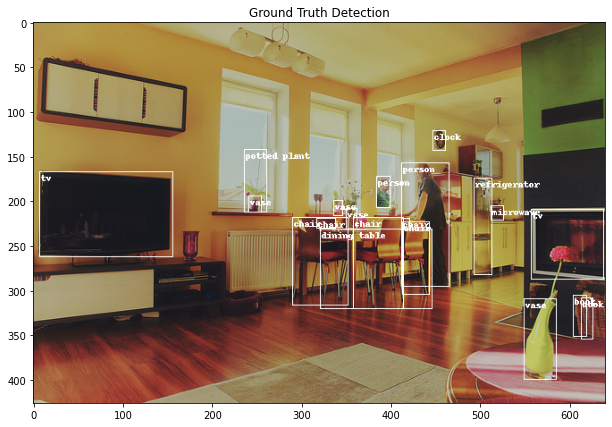

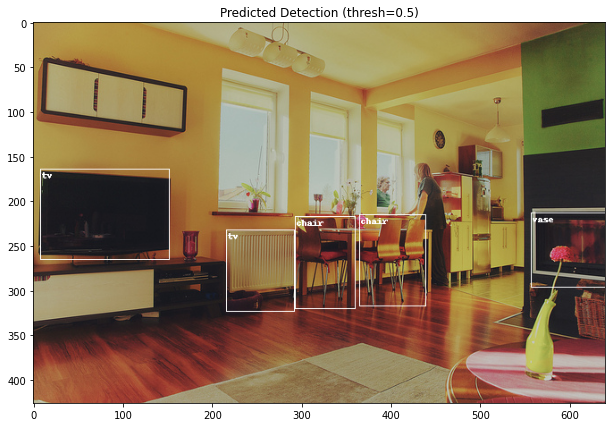

In [86]:
# Parameters
img_id = 139 #11051 # 67406
th = 0.5  # threshold for confidence score of predicted bboxes to show

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id]))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img])
  else:    
    pred = model([img_torchvision])

# Get label names
label_ids = dataset.coco.getCatIds()
label_info = dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Get ground truth bboxes
true_bboxes = convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

# Get ground truth segmentation masks
# print(img_anns)
# true_masks = F.Tensor([obj['segmentation'][0] for obj in img_anns])
# true_labels = [labels[obj['category_id']] for obj in img_anns]
# true_img = U.draw_segmentation_masks(img, true_masks, true_labels)
# plt.figure(figsize = (25,7))
# plt.imshow(F.to_pil_image(true_img))

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_labels = []
  yolo_labels = pred.names
  for img in pred.xyxy:
    for bbox in img:
      if bbox[4] > th:  # Show only bboxes with high confidence score
        pred_bboxes.append(bbox[:4])
        pred_labels.append(labels[labels_inv[yolo_labels[int(bbox[5])]]])  # Convert YOLO label to COCO label
  pred_bboxes = torch.stack(pred_bboxes)
# For torchvision models
else:
  pred_bboxes = torch.stack([pred[0]['boxes'][i] for i in range(0,len(pred[0]['boxes'])) if pred[0]['scores'][i] > th])  # Show only bboxes with high confidence score
  pred_labels_ids = torch.stack([pred[0]['labels'][i] for i in range(0,len(pred[0]['labels'])) if pred[0]['scores'][i] > th]).tolist()
pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels)
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### Evaluate model on dataset

In [38]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Evaluate model
evaluator, outputs = evaluate(model, data_loader, device)



Test:  [   0/2500]  eta: 0:17:50  model_time: 0.1707 (0.1707)  evaluator_time: 0.0217 (0.0217)  time: 0.4283  data: 0.2020  max mem: 241
Test:  [ 100/2500]  eta: 0:05:53  model_time: 0.0988 (0.1052)  evaluator_time: 0.0099 (0.0120)  time: 0.1435  data: 0.0038  max mem: 241
Test:  [ 200/2500]  eta: 0:05:33  model_time: 0.1030 (0.1042)  evaluator_time: 0.0081 (0.0119)  time: 0.1409  data: 0.0043  max mem: 241
Test:  [ 300/2500]  eta: 0:05:16  model_time: 0.1036 (0.1038)  evaluator_time: 0.0103 (0.0118)  time: 0.1447  data: 0.0042  max mem: 241
Test:  [ 400/2500]  eta: 0:05:01  model_time: 0.0953 (0.1036)  evaluator_time: 0.0101 (0.0118)  time: 0.1412  data: 0.0037  max mem: 241
Test:  [ 500/2500]  eta: 0:04:47  model_time: 0.1014 (0.1039)  evaluator_time: 0.0098 (0.0116)  time: 0.1463  data: 0.0042  max mem: 241
Test:  [ 600/2500]  eta: 0:04:33  model_time: 0.1026 (0.1045)  evaluator_time: 0.0104 (0.0117)  time: 0.1467  data: 0.0034  max mem: 241
Test:  [ 700/2500]  eta: 0:04:21  model_t

## Save results

In [ ]:
results = []
for i, img_id in enumerate(img_ids):  # For every image
  img_predictions = predictions[i]
  pred_boxes = img_predictions['boxes'].tolist()
  pred_labels = img_predictions['labels'].tolist()
  pred_scores = img_predictions['scores'].tolist()
  for j in range(0,len(pred_box)):  # For every predicted object
    pred_box = pred_boxes[j]
    results.append({
        'image_id': img_id,
        'category_id': pred_labels[j],
        'bbox': [round(val,1) for val in pred_box],  # Round for lower file size
        'score': pred_scores[j]
        })

results_file = os.path.join(img_dir,f'{model_id}_coco17_results.json')
with open(results_file, 'w') as outfile: 
    json.dump(results, outfile,indent = 2)



In [ ]:
files.download(results_file) 

In [ ]:
# results_dataset = dataset.loadRes(results_file)
# eval = cocoeval.COCOeval(dataset, results_dataset, iouType='bbox')
# eval.evaluate()
# eval.accumulate()
# eval.summarize()

